In [1]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../models/mode_cnn_uh_201009/neuron_activations_cnn_20200504_000_val.csv')
df.time = df.time.astype('datetime64[ns]').reset_index(drop=True) - pd.Timedelta(6, 'H') # convert to datetime64 object and offset from UTC time by 6 hours
df.describe()

,index,centroid_lon,centroid_lat,centroid_i,centroid_j,track_id,track_step,neuron_000,neuron_001,neuron_002,neuron_003,neuron_004,neuron_005,neuron_006,neuron_007,neuron_008
count,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000,187184.000000
mean,93591.500000,-91.936123,38.184899,512.676789,953.536413,760.630828,1.831417,-0.012562,-0.062152,0.403513,0.026497,-0.057581,-0.001550,0.648481,0.243555,-0.000809
std,54035.510731,9.784797,5.036332,185.785259,279.046159,512.925881,1.223256,0.003577,0.000876,0.118998,0.048404,0.000746,0.000007,0.108295,0.148802,0.000048
min,0.000000,-124.432205,24.692507,41.000000,49.000000,0.000000,1.000000,-0.021408,-0.062751,-0.255929,-0.076717,-0.058209,-0.001630,-0.185951,-0.673281,-0.000845
25%,46795.750000,-98.237195,34.247490,365.000000,768.000000,337.000000,1.000000,-0.013533,-0.062591,0.388387,0.005035,-0.057958,-0.001551,0.640460,0.159097,-0.000833
50%,93591.500000,-90.886940,37.986687,507.000000,982.000000,692.000000,1.000000,-0.013292,-0.062466,0.451739,0.010953,-0.057850,-0.001551,0.690168,0.308109,-0.000827
75%,140387.250000,-85.001309,42.037640,659.000000,1159.000000,1109.000000,2.000000,-0.012532,-0.062104,0.472436,0.027203,-0.057536,-0.001549,0.706403,0.359152,-0.000805
max,187183.000000,-67.522270,49.320774,944.000000,1538.000000,2443.000000,19.000000,0.220549,-0.045624,0.780026,0.922816,-0.043549,-0.001401,0.755583,0.406062,0.001520


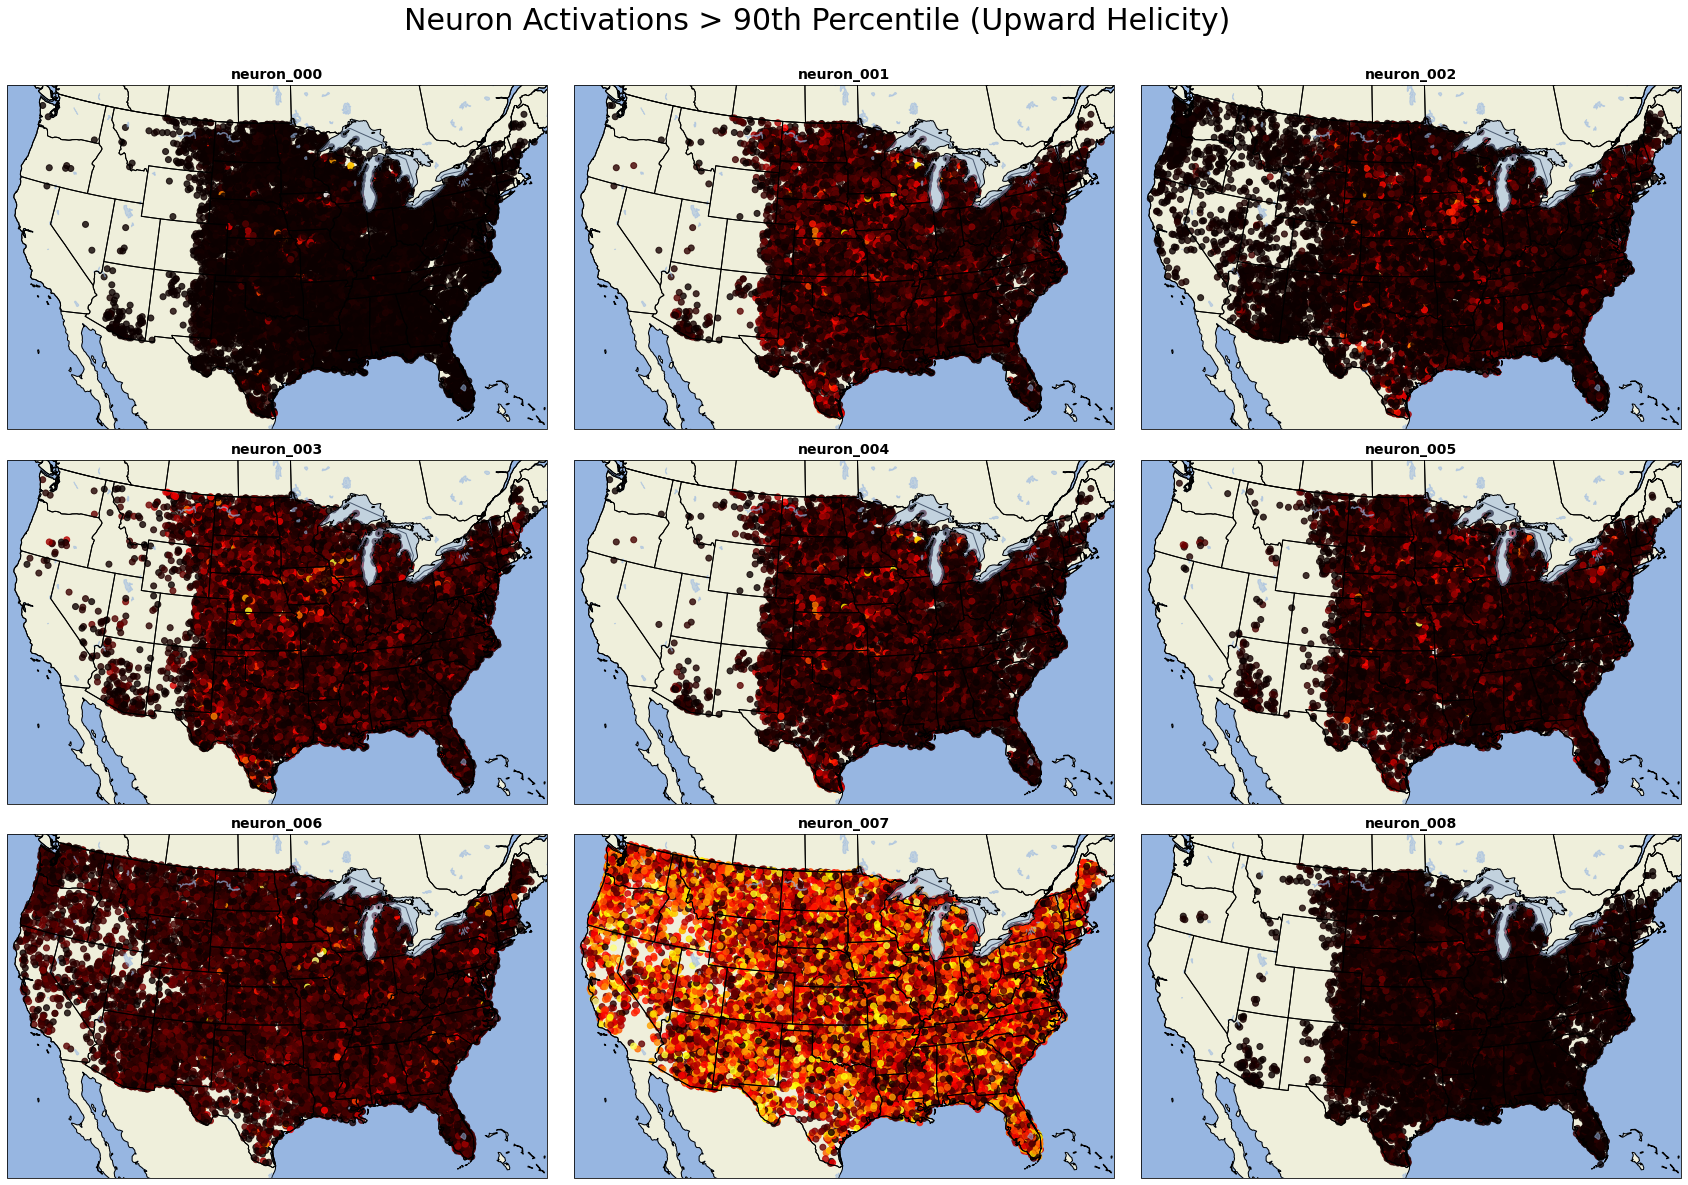

In [3]:
lcc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, axes = plt.subplots(3,3, figsize=(30, 19.6), sharex=True, sharey=True, subplot_kw={'projection': lcc})
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
neurons = list(df.columns[-9:])
for i, ax in enumerate(axes.ravel()):
    ax.set_extent([-120, -74, 25, 50], crs=ccrs.PlateCarree()) 
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    
    neuron = neurons[i]
    #data = df[df[neuron] < df[neuron].quantile(0.1)]
    data = df[df[neuron] > df[neuron].quantile(0.90)]
    var = data[neuron]
    #vmax = data.iloc[:,-4:].max().max()
    #vmin = data.iloc[:,-4:].min().min()
    vmin = var.quantile(0)
    vmax = var.quantile(1)
    im = ax.scatter(data['centroid_lon'], data['centroid_lat'], c=var, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), alpha=0.8, cmap='hot')
    ax.set_title(neuron, fontsize=14, fontweight='bold')
    
#fig.subplots_adjust(right=0.87)
#cbar_ax = fig.add_axes([0.88, 0.132, 0.015, 0.74])
#fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Neuron Activations > 90th Percentile (Upward Helicity)', fontsize=30)
fig.subplots_adjust(top=0.95)
fig.savefig('../images/Storms_greater90p_uh.png', bbox_inches='tight')

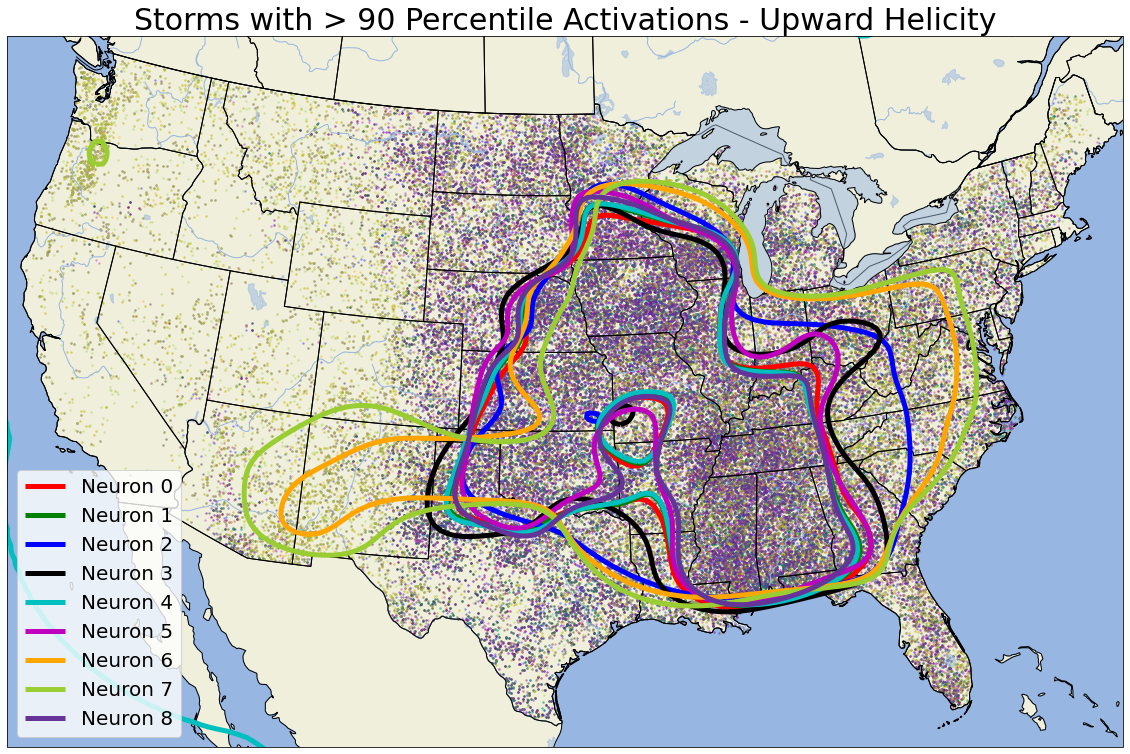

In [10]:
neurons = list(df.columns[-9:])
col = ['r', 'g', 'b', 'k', 'c', 'm', 'orange', 'yellowgreen', 'rebeccapurple']
fig = plt.figure(figsize=(20, 16))
lcc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
ax = fig.add_subplot(1, 1, 1, projection=lcc)
ax.set_extent([-120, -74, 25, 50], crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)

for i in range(9):
    neuron = neurons[i]
    data = df[df[neuron] > df[neuron].quantile(0.9)]
    #data = df[df[neuron] > 0.1]
    var = data[neuron]
    plt.scatter(data['centroid_lon'], data['centroid_lat'], transform=ccrs.PlateCarree(), label=None, color=col[i], alpha=0.25, s=2.5)
    sns.kdeplot(data['centroid_lon'], data['centroid_lat'], levels=3, transform=ccrs.PlateCarree(), linewidths=5, thresh=0, color=col[i], linestyles='-',
                label=f'Neuron {i}', cummulative=True)
    plt.legend(prop={'size': 20})
plt.title('Storms with > 90 Percentile Activations - Upward Helicity', fontsize=30)
fig.savefig('../images/ML_Storms_greater90_uh.png', bbox_inches='tight')

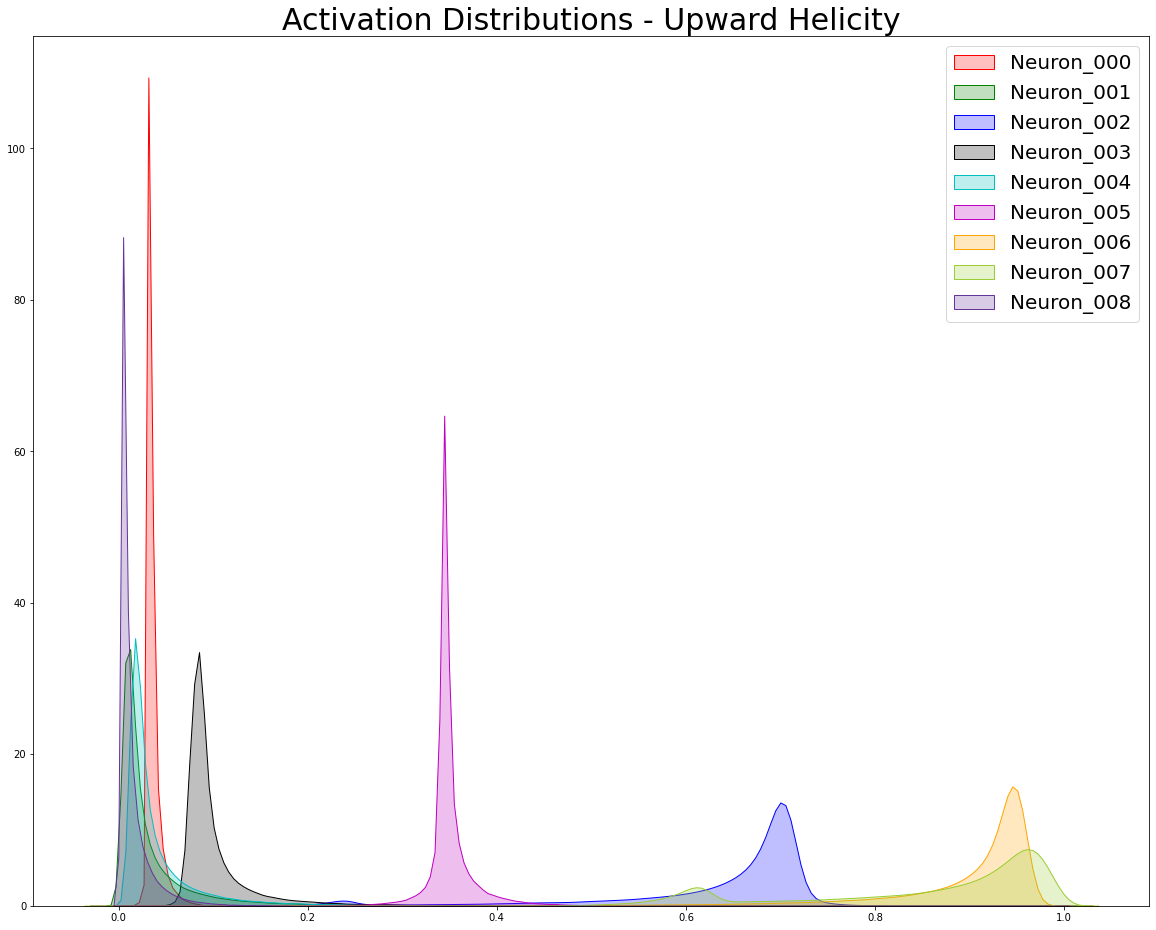

In [5]:
scaler = MinMaxScaler()
s_data = df.iloc[:, -9:]
#s_data = s_data[s_data['neuron_003'] > s_data['neuron_003'].quantile(0.90)]
sdf = pd.DataFrame(scaler.fit_transform(s_data), columns=s_data.columns)
col = ['r', 'g', 'b', 'k', 'c', 'm', 'orange', 'yellowgreen', 'rebeccapurple']

plt.figure(figsize=(20,16))
for i in range(9):
    sns.kdeplot(sdf.iloc[:,i], shade=True, label=f'Neuron_00{i}', color=col[i])
    plt.legend(prop={'size': 20})
plt.ylabel('')
plt.xlabel('')
plt.title('Activation Distributions - Upward Helicity', fontsize=30)
plt.savefig('../images/kde_dist_uh.png', bbox_inches='tight')

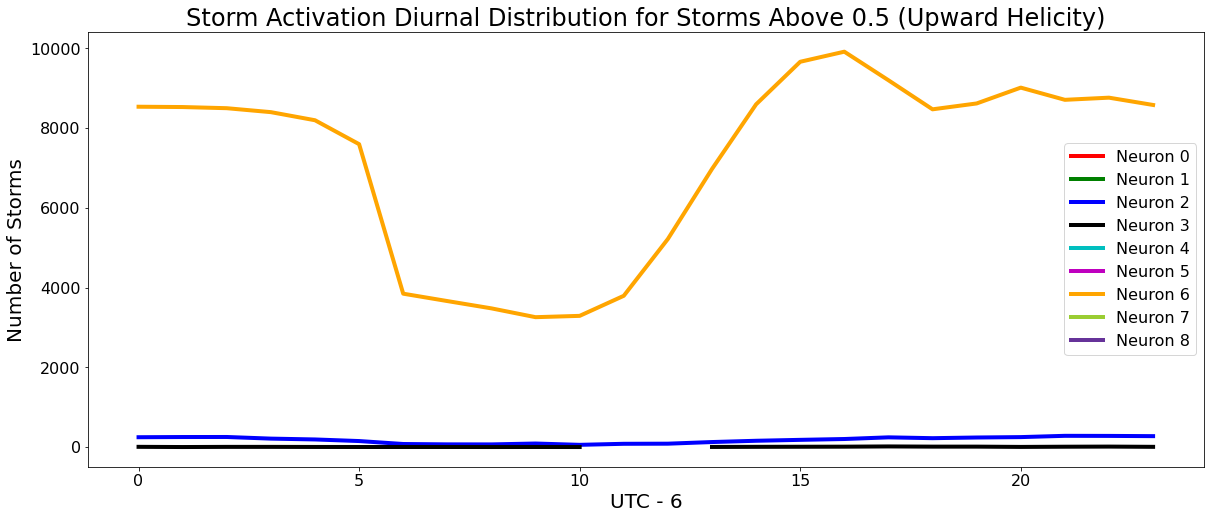

In [6]:
neurons = list(df.columns[-9:])
dff = pd.DataFrame(columns=neurons)
fig, ax = plt.subplots(figsize=(20,8))
col = ['r', 'g', 'b', 'k', 'c', 'm', 'orange', 'yellowgreen', 'rebeccapurple']

for i in range(9):
    neuron = neurons[i]
    #d = df[df[neuron] > df[neuron].quantile(0.50)].groupby(df['time'].dt.hour)[neuron].count()
    d = df[df[neuron] > 0.5].groupby(df['time'].dt.hour)[neuron].count()
    dff[neuron] = d
    im = ax.plot(dff[neuron], linewidth=4, alpha=1, label=f'Neuron {i}', color=col[i])
plt.legend(prop={'size': 16})
plt.title('Storm Activation Diurnal Distribution for Storms Above 0.5 (Upward Helicity)', fontsize=24)
ax.set_ylabel('Number of Storms', fontsize=20)
ax.set_xlabel('UTC - 6', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.savefig('../images/Diurnal_g50p_uh.png', bbox_inches='tight')

In [7]:
neurons = df.columns[-9:]
l, ids = [], []
for n in neurons:
    t = df[df[n] == df[n].max()]['time'] + pd.Timedelta(6, 'H')
    i = df[df[n] == df[n].max()]['track_id']
    l.append(t)
    ids.append(i)

l, ids

([148905   2014-06-30 19:00:00
  Name: time, dtype: datetime64[ns],
  87111   2014-06-05 12:00:00
  Name: time, dtype: datetime64[ns],
  82955   2014-06-03 23:00:00
  Name: time, dtype: datetime64[ns],
  110493   2014-06-16 21:00:00
  Name: time, dtype: datetime64[ns],
  87111   2014-06-05 12:00:00
  Name: time, dtype: datetime64[ns],
  87977   2014-06-06 04:00:00
  Name: time, dtype: datetime64[ns],
  60516   2014-05-21 22:00:00
  Name: time, dtype: datetime64[ns],
  167111   2014-07-10 18:00:00
  Name: time, dtype: datetime64[ns],
  110973   2014-06-17
  Name: time, dtype: datetime64[ns]],
 [148905    337
  Name: track_id, dtype: int64,
  87111    391
  Name: track_id, dtype: int64,
  82955    500
  Name: track_id, dtype: int64,
  110493    285
  Name: track_id, dtype: int64,
  87111    391
  Name: track_id, dtype: int64,
  87977    872
  Name: track_id, dtype: int64,
  60516    267
  Name: track_id, dtype: int64,
  167111    588
  Name: track_id, dtype: int64,
  110973    556
  Name